In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import imageio.v2 as imageio # Throws warning otherwise
from matplotlib import pyplot as plt

# The Mechanics of Learning
- Jackson Cown
- 6/13/2022


This chapter covers:
- Understanding how algorithms can learn from data
- Reframing learning as parameter estimation, using differentiation and gradient descent
- Walking through a simple learning algorithm
- How PyTorch supports learning with autograd


Post-Chapter Summary:
- Linear model are the simplest reasonable model to fit data
- Convex optimization techniques can be used for linear models, but they do not generalize to neural networks, so we focus on stochastic gradient descent for parameter estimation
- Deep learning can be used for generic models that are not engineered for solving a specific task, but instead can automatically adapt to specialize themselves for the task at hand
- Learning algorithms amount to optimizing parameters of models based on observations. A loss function is a measure of the error in carrying out a task, such as error between predicted outputs and measured values.
- The rate of change of the loss function with respect to the model parameters can be used to update the parameters in the direction of decreasing loss
- The ```optim``` module in PyTorch provides a collection of ready-to-use optimizers for updating parameters and minimizing loss functions
- Optimizers uses the autograd feature of PyTorch to compute the gradient for each parameter, depending on how that parameter contributes to the final output. This allows users to rely on the dynamic computation graph during complex forward passes

How do machines learn?
- A learning algorithm is presented with input data that is paired with desired output data. Once learning has occured, that algorithm is capable of producing correct outputs when it is fed new data that is *similar enough* to the data it was trained on.
    - With Deep Learning, this process works even when input data and the desired output are *far* from each other:
        - When they come from two different domains, like an image and a sentence describing it

### A timeless lesson in modeling
- Example: Kepler determining the laws of orbital motion
- Over 6 Years, Kepler:
    1. Got lots of good data from his friend through naked eye observations
    2. Tried to visualize the orbital problem he was trying to solve
    3. Choose the simplest possible model that had a chance to fit the data
    4. Split the data so he could work on part of it and keep an independent set for validation
    5. Started with a tentative eccentricity and size for the ellipse and iterated until the model fit the observations
    6. Validated his model on the independent observations
    7. Drew reasonable conclusions about the efficacy of his model
- These experimental design patterns are prototypical of modern Data Science procedures
- In this book, there is no difference between saying we will *fit* the data or saying we will make an algorithm *learn* from data.
    - The process always involves a function with a number of unknown parameters whose values are estimated from data: in short, a *model*
- We can argue that *learning from data* presumes the underlying model is not engineereed to solve a specific task and instead capable of approximating a much wider family of functions.
- In this book, we are interested in models that are not engineered to solve a specific, narrow task, but that can be automatically adapted to specialize themselves for any one of many similar tasks using inputs and output pairs
    - i.e., General models trained on data relevant to the specific task at hand
    - In particular, PyTorch is designed to make it easy to create models for which derivatives of the fitting error, with respect to parameters, can be expressed analytically.
- This chapter is about how to automate general function-fitting
    - We will start with a model that is much simpler than a deep neural network


### Learning is just a parameter estimation
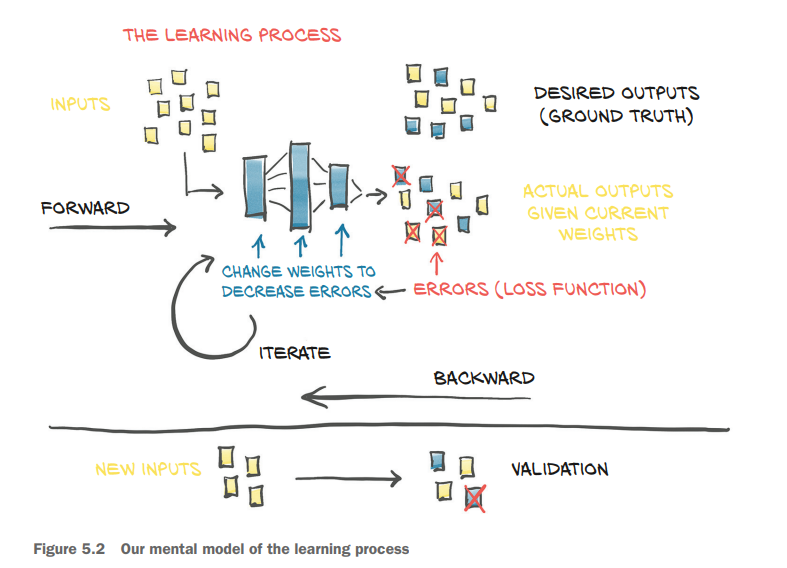
- Given input data and corresponding outputs (ground truth), as well as initial values for the weights, the model is fed input data, and a measure of the error is evaluated by comparing the resulting outputs to the ground truth
- In order to optimize the the model parameters (weights), the error following a unit change in weights (that is, the *gradient* of the error with respect to the parameters) is computed using the chain rule of calculus and backpropagated throughout the network
- The value of weights in the network is updated according to a composition of this gradient and a learning rate
- This procedure is repeated until the error of resulting model outputs is within a tolerable level


Now we will take a problem with a noisy dataset, build a model, and implement a learning algorithm for it
- We will starting by just showing how learning can occur on the component of a neural network so we can juxtapose the behavior to a full network


#### A hot problem
- Understanding unlabeled temperature units

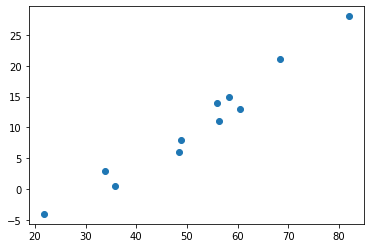

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # Temp in celcius
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # Temp in ambiguous units
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
plt.scatter(t_u, t_c)
plt.show()

#### Choosing a linear model as a first try
We can see that there is a strong linear relationship just from the data we just plotted
- We assume the simplest possible model for converting between arbitrary units and celcius
- Example Linear model:
    - ```t_c = w * t_u + b```
    - Multiply the arbitrary units by a factor and add a constant
    - Weights and biases
        - Weights tell us how much a given input influence the output.
        - Bias is what the output would be if all inputs were zero
- Now we need to estimate the values of ```w``` and ```b``` based on the data we have
- We have a model with some unknown parameters, and we need to estimate those parameters so that the error in outputs is as low as possible
    - We need to explicitly define a measure of error
    - We refer to the measurement of error on a given task as the *loss function* (or *objective function* or *cost function* or *criterion*)
        - Lots of different terms for loss
- Our optimization should find a ```w``` and ```b``` that minimizes our loss function


### Less loss is what we want
- A *loss function* is a function that conmputes a single numerical value that the learning process will attempt to minimize
    - A standard loss function involves taking the difference between predicted output and desired output.
        - In the temp case, this would be the different between t_p and t_c
    - We need to make sure that the loss function makes the loss positive when we either over or undershoot the true value, that way we can hone in on a single local minima instead of the gradient always being in one direction.
        - We can achieve this by taking the absolute value of the difference between prediction and ground truth
        - Other common methods involve squaring the difference
        - Both of these examples have a clear minima at zero and grow monotonically
            - Since the gradient also grows monotonically, both of them are said to be *convex*
            - Since our model is linear, the loss function of ```w``` and ```b``` is also said to be *convex*
                - It's worth noting that deeper neural networks are notoriously non-convex
        - We can choose between many loss functions to encode certain behaviors into our model while training
    - Conceptually, a loss function is just a way of prioritizing which errors to fix in our training samples and how they influence model parameter updates
- Cases where the loss function is a convex function of the model parameters are usually great to deal with because we have very efficient algorithms to find the minimum
- However, we will use less powerful, but more generally applicable methods in this chapter
    - This is because in neural networks, loss is very rarely convex with respect to the parameters
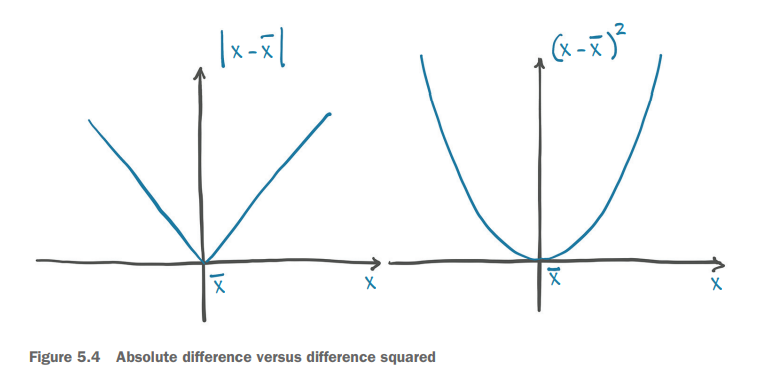
- You can see in the image above both of these loss functions have clear global minima
- 

#### From problem back to PyTorch

In [3]:
# Defining a simple linear model
def model(t_u, w, b):
    return w * t_u + b # Simple linear transformation

In [4]:
# Defining a loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2 # Compute squared difference between prediction and ground truth
    return squared_diffs.mean() # Compute the average squared difference over each sample


In [5]:
# Init weights and bias
# w and b are size 0, allowing torch to replicate the element along any necessary axis via broadcasting
w = torch.ones(())
b = torch.zeros(()) # Note how the dimension for these are zero
print(f'Shape of weights: {w.shape}\n')

# Run the linear model
t_p = model(t_u, w, b) # Computes tensor of predictions
print(f'Predicted output: {t_p}\n')
print(f'Ground truth: {t_c}') # It looks clear to me we are mapping from fahrenheit to celcius
# Notice that 35 in the unknown units is near 0 in celcius

Shape of weights: torch.Size([])

Predicted output: tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

Ground truth: tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000])


In [6]:
# Compute the loss from what we expect it to map to
loss = loss_fn(t_p, t_c)
print(loss) # Average loss across all samples; very high

tensor(1763.8848)


#### Broadcasting Aside:
- Without broadcasting, we can only use element-wise binary operations such as addition, subtraction, multiplication, and division for arguments with the same shape
    - The entries with matching positions in each of the tensors will be used to compute the corresponding entry in the result vector
- Broadcasting relaxes this assumption for most binary operations. It uses the following rules to match tensor elements:
    - For each index dimension, counted from the back, if one of the operands is size 1 in that dimension, PyTorch will use the single entry along this dimension with each of the entries in the other tensor along this dimension
    - If both sizes are greater than 1, they must be the same, and natural matching is used
    - If one of the tensors has more index dimensions than the other, the entirety of the tensor will be used for each entry along these dimensions
    

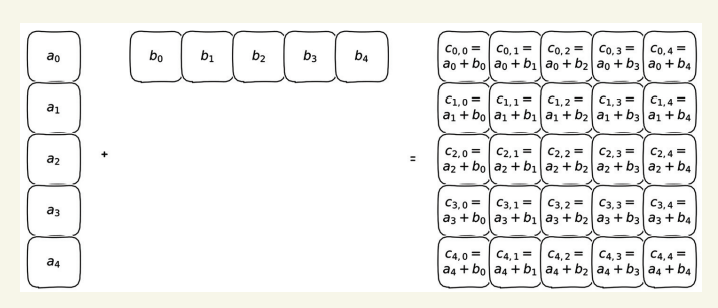


Broadcasting code example:

In [7]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)
print(f'Shapes: ')
print(f'x: {x.shape}, y: {y.shape}, z: {z.shape}, a: {a.shape}')

Shapes: 
x: torch.Size([]), y: torch.Size([3, 1]), z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])


In [8]:
print(f'x * y: {(x * y).shape}')
print(f'y * z: {(y * z).shape}')
print(f'y * z * a: {(y * z * a).shape}')

x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


### Down along the gradient
- We will optimize our function with respect to our parameters using the *gradient descent* algorithm
- Gradient descent is a simple idea, and it scales up surprisingly well to large neural network models with millions of parameters
- Main Idea: Move the parameters in the direction of decreasing loss until we converge at a minimum


#### Decreasing loss
- Compute the rate of change of the loss with respect to each parameter, then modify each parameter in the direction of decreasing loss
- We can do numerical differentiation by adding a small number to w and seeing how much the loss changes

In [13]:
# Numerical derivation
delta = 0.1
learning_rate = 1e-2
# Compute loss rate of change (w.r.t model weights)
loss_roc_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
print(loss_roc_w)
w = w - (learning_rate * loss_roc_w)
print(w)

tensor(-261170.)
tensor(2567.5269)


In [15]:
# Compute loss rate of change (w.r.t model bias)
loss_roc_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - (learning_rate * loss_roc_b)
print(b)

tensor(-5120.)


### PyTorch's autograd: Backpropagating all things





#### Computing the gradient automatically